In [1]:
from shared.preface import *
import shared.functions as fct
import shared.my_units as my
import shared.control_center as CC

7.040459222580244
0.26982962391830506
0.26982962391830506
0.26982962391830506


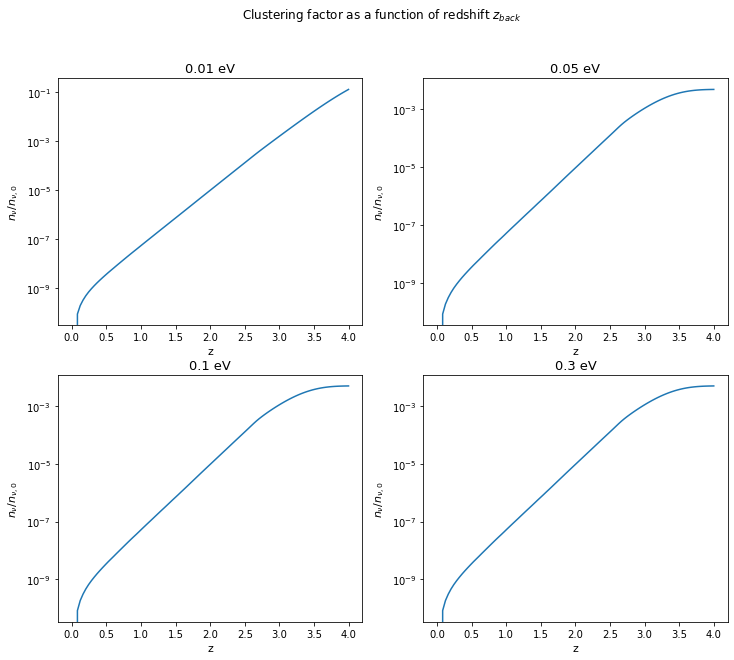

In [2]:
def n_nu_of_redshift(m_nu_eV):

    # Amount of simulated neutrinos
    Ns = np.arange(CC.NR_OF_NEUTRINOS, dtype=int)

    # load initial and final velocity
    u0 = [np.load(f'neutrino_vectors/nu_{Nr+1}.npy')[0][3:6] for Nr in Ns]
    u1 = [np.load(f'neutrino_vectors/nu_{Nr+1}.npy')[-1][3:6] for Nr in Ns]

    # magnitude of velocities
    m0 = np.array([np.sqrt(np.sum(u**2)) for u in np.array(u0)])*my.Uunit
    m1 = np.array([np.sqrt(np.sum(u**2)) for u in np.array(u1)])*my.Uunit

    z_array = np.linspace(CC.Z_START, CC.Z_STOP, CC.Z_AMOUNT)

    n_nus = np.zeros(len(z_array))
    for i, z in enumerate(z_array):

        # convert velocities from [kpc/s] to [m/s]
        ms0, ms1 = m0.to(unit.m/unit.s), m1.to(unit.m/unit.s)

        # multiplt mass of sim. [kg] and c to get unit [kg m**2 / s**2], i.e. J
        cf = CC.NU_MASS_KG * const.c
        m0J, m1J = ms0*cf, ms1*cf

        # convert from [Joule] to [eV]
        m0_eV, m1_eV = m0J.to(unit.eV), m1J.to(unit.eV)

        # multiply mass ratio, to scale momenta to new neutrino mass we want
        m_ratio = (m_nu_eV / CC.NU_MASS).value
        p0_eV, p1_eV = m0_eV*m_ratio, m1_eV*m_ratio

        # calculate number density with momenta in [eV]
        n_nus[i] = fct.number_density(p0_eV[:i], p1_eV[:i], z).value


    np.save(f'neutrino_data/number_densities_at_z_{m_nu_eV.value}eV.npy', n_nus)


z_array = np.linspace(CC.Z_START, CC.Z_STOP, CC.Z_AMOUNT)

fig, axs = plt.subplots(2,2, figsize=(12,10))
fig.suptitle(r'Clustering factor as a function of redshift $z_{back}$')

masses = np.array([0.01, 0.05, 0.1, 0.3])*unit.eV
for j, m in enumerate(masses):
    n_nu_of_redshift(m)

    n_nus = np.load('neutrino_data/number_densities_at_z_0.05eV.npy')

    i = 0
    if j in (2,3):
        i = 1
        j -= 2

    axs[i,j].semilogy(z_array, n_nus/56)
    axs[i,j].set_title(f'{m.value} eV')
    axs[i,j].set_xlabel('z')
    axs[i,j].set_ylabel(r'$n_{\nu} / n_{\nu, 0}$')
    print(n_nus[-1])

plt.savefig('check_plots/figure_4.pdf')
plt.show()

#! Values don't start at redshift 0 exactly, since z array starts at 1e-10.